In this notebook, we will build an abstractive based text summarizer using deep learning from the scratch in python using keras

I recommend you to go through the article over [here](https://www.analyticsvidhya.com/blog/2019/06/comprehensive-guide-text-summarization-using-deep-learning-python/) to cover all the concepts which is required to build our own summarizer

#Understanding the Problem Statement

Customer reviews can often be long and descriptive. Analyzing these reviews manually, as you can imagine, is really time-consuming. This is where the brilliance of Natural Language Processing can be applied to generate a summary for long reviews.

We will be working on a really cool dataset. Our objective here is to generate a summary for the Amazon Fine Food reviews using the abstraction-based approach we learned about above. You can download the dataset from[ here ](https://www.kaggle.com/snap/amazon-fine-food-reviews)

It’s time to fire up our Jupyter notebooks! Let’s dive into the implementation details right away.

#Custom Attention Layer

Keras does not officially support attention layer. So, we can either implement our own attention layer or use a third-party implementation. We will go with the latter option for this article. You can download the attention layer from [here](https://github.com/thushv89/attention_keras/blob/master/layers/attention.py) and copy it in a different file called attention.py.

Let’s import it into our environment:

In [1]:
!pip install attention

In [2]:
from tensorflow.keras.layers import Attention

#Import the Libraries

In [3]:
import numpy as np
import pandas as pd
import re
from bs4 import BeautifulSoup
from keras.preprocessing.text import Tokenizer
from keras.utils.data_utils import pad_sequences
from nltk.corpus import stopwords
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

#Read the dataset

This dataset consists of reviews of fine foods from Amazon. The data spans a period of more than 10 years, including all ~500,000 reviews up to October 2012. These reviews include product and user information, ratings, plain text review, and summary. It also includes reviews from all other Amazon categories.

We’ll take a sample of 100,000 reviews to reduce the training time of our model. Feel free to use the entire dataset for training your model if your machine has that kind of computational power.

In [4]:
!pip install datasets

In [5]:
#data=pd.read_csv("../input/amazon-fine-food-reviews/Reviews.csv",nrows=100000)
# Load XSum dataset from Hugging Face datasets library
from datasets import load_dataset

dataset = load_dataset("xsum", "1.0.0")

# Select and preprocess a subset of the dataset (100 data points)
subset_size = 10
subset_dataset = dataset["train"].select(range(subset_size))


data = {"Text": dataset["train"]["document"], "Summary": dataset["train"]["summary"]}
df = pd.DataFrame(data)
data=df.head(10)
data

,Text,Summary
0,"The full cost of damage in Newton Stewart, one of the areas worst affected, is still being assessed.\nRepair work is ongoing in Hawick and many roads in Peeblesshire remain badly affected by stand...",Clean-up operations are continuing across the Scottish Borders and Dumfries and Galloway after flooding caused by Storm Frank.
1,"A fire alarm went off at the Holiday Inn in Hope Street at about 04:20 BST on Saturday and guests were asked to leave the hotel.\nAs they gathered outside they saw the two buses, parked side-by-si...",Two tourist buses have been destroyed by fire in a suspected arson attack in Belfast city centre.
2,"Ferrari appeared in a position to challenge until the final laps, when the Mercedes stretched their legs to go half a second clear of the red cars.\nSebastian Vettel will start third ahead of team...",Lewis Hamilton stormed to pole position at the Bahrain Grand Prix ahead of Mercedes team-mate Nico Rosberg.
3,"John Edward Bates, formerly of Spalding, Lincolnshire, but now living in London, faces a total of 22 charges, including two counts of indecency with a child.\nThe 67-year-old is accused of committ...","A former Lincolnshire Police officer carried out a series of sex attacks on boys, a jury at Lincoln Crown Court was told."
4,Patients and staff were evacuated from Cerahpasa hospital on Wednesday after a man receiving treatment at the clinic threatened to shoot himself and others.\nOfficers were deployed to negotiate wi...,"An armed man who locked himself into a room at a psychiatric hospital in Istanbul has ended his threat to kill himself, Turkish media report."
5,"Simone Favaro got the crucial try with the last move of the game, following earlier touchdowns by Chris Fusaro, Zander Fagerson and Junior Bulumakau.\nRynard Landman and Ashton Hewitt got a try in...",Defending Pro12 champions Glasgow Warriors bagged a late bonus-point victory over the Dragons despite a host of absentees and two yellow cards.
6,"Veronica Vanessa Chango-Alverez, 31, was killed and another man injured when an Audi A3 struck them in Streatham High Road at 05:30 GMT on Saturday.\nTen minutes before the crash the car was in Lo...",A man with links to a car that was involved in a fatal bus stop crash in south London is being sought by police.
7,Belgian cyclist Demoitie died after a collision with a motorbike during Belgium's Gent-Wevelgem race.\nThe 25-year-old was hit by the motorbike after several riders came down in a crash as the rac...,Welsh cyclist Luke Rowe says changes to the sport must be made following the death of Antoine Demoitie.
8,"Gundogan, 26, told BBC Sport he ""can see the finishing line"" after tearing cruciate knee ligaments in December, but will not rush his return.\nThe German missed the 2014 World Cup following back s...",Manchester City midfielder Ilkay Gundogan says it has been mentally tough to overcome a third major injury.
9,"The crash happened about 07:20 GMT at the junction of the A127 and Progress Road in Leigh-on-Sea, Essex.\nThe man, who police said is aged in his 20s, was treated at the scene for a head injury an...","A jogger has been hit by an unmarked police car responding to an emergency call, leaving him with ""serious life-changing injuries""."


# Drop Duplicates and NA values

In [6]:
data.drop_duplicates(subset=['Text'],inplace=True)#dropping duplicates
data.dropna(axis=0,inplace=True)#dropping na

# Information about dataset

Let us look at datatypes and shape of the dataset

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10 entries, 0 to 9
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Text     10 non-null     object
 1   Summary  10 non-null     object
dtypes: object(2)
memory usage: 240.0+ bytes


#Preprocessing

Performing basic preprocessing steps is very important before we get to the model building part. Using messy and uncleaned text data is a potentially disastrous move. So in this step, we will drop all the unwanted symbols, characters, etc. from the text that do not affect the objective of our problem.

Here is the dictionary that we will use for expanding the contractions:

In [8]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

We will perform the below preprocessing tasks for our data:

1.Convert everything to lowercase

2.Remove HTML tags

3.Contraction mapping

4.Remove (‘s)

5.Remove any text inside the parenthesis ( )

6.Eliminate punctuations and special characters

7.Remove stopwords

8.Remove short words

Let’s define the function:

In [9]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [10]:
stop_words = set(stopwords.words('english'))

def text_cleaner(text,num):
    newString = text.lower()
    newString = BeautifulSoup(newString, "lxml").text
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString)
    newString = re.sub('[m]{2,}', 'mm', newString)
    if(num==0):
        tokens = [w for w in newString.split() if not w in stop_words]
    else:
        tokens=newString.split()
    long_words=[]
    for i in tokens:
        if len(i)>1:                                                 #removing short word
            long_words.append(i)
    return (" ".join(long_words)).strip()

In [11]:
#call the function
cleaned_text = []
for t in data['Text']:
    cleaned_text.append(text_cleaner(t,0))

Let us look at the first five preprocessed reviews

In [12]:
cleaned_text[:5]

['full cost damage newton stewart one areas worst affected still assessed repair work ongoing hawick many roads peeblesshire remain badly affected standing water trains west coast mainline face disruption due damage lamington viaduct many businesses householders affected flooding newton stewart river cree overflowed town first minister nicola sturgeon visited area inspect damage waters breached retaining wall flooding many commercial properties victoria street main shopping thoroughfare jeanette tate owns cinnamon cafe badly affected said could fault multi agency response flood hit however said preventative work could carried ensure retaining wall fail difficult think much publicity dumfries nith totally appreciate almost like neglected forgotten said may true perhaps perspective last days ready help us bit warning alarm alerts gone meanwhile flood alert remains place across borders constant rain peebles badly hit problems sparking calls introduce defences area scottish borders council

In [13]:
#call the function
cleaned_summary = []
for t in data['Summary']:
    cleaned_summary.append(text_cleaner(t,1))

Let us look at the first 10 preprocessed summaries

In [14]:
cleaned_summary[:10]

['clean up operations are continuing across the scottish borders and dumfries and galloway after flooding caused by storm frank',
 'two tourist buses have been destroyed by fire in suspected arson attack in belfast city centre',
 'lewis hamilton stormed to pole position at the bahrain grand prix ahead of mercedes team mate nico rosberg',
 'former lincolnshire police officer carried out series of sex attacks on boys jury at lincoln crown court was told',
 'an armed man who locked himself into room at psychiatric hospital in istanbul has ended his threat to kill himself turkish media report',
 'defending pro champions glasgow warriors bagged late bonus point victory over the dragons despite host of absentees and two yellow cards',
 'man with links to car that was involved in fatal bus stop crash in south london is being sought by police',
 'welsh cyclist luke rowe says changes to the sport must be made following the death of antoine demoitie',
 'manchester city midfielder ilkay gundogan 

In [15]:
data['cleaned_text']=cleaned_text
data['cleaned_summary']=cleaned_summary

#Drop empty rows

In [16]:
data.replace('', np.nan, inplace=True)
data.dropna(axis=0,inplace=True)

#Understanding the distribution of the sequences

Here, we will analyze the length of the reviews and the summary to get an overall idea about the distribution of length of the text. This will help us fix the maximum length of the sequence:

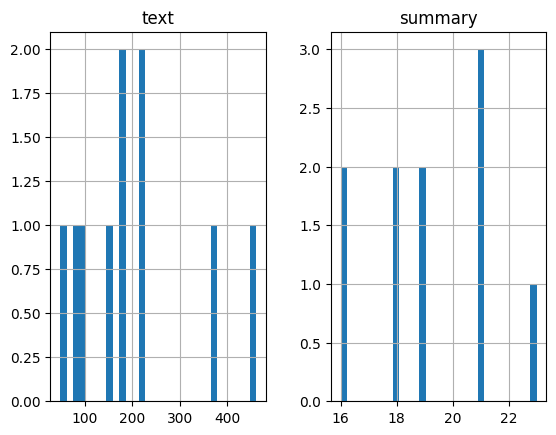

In [17]:
import matplotlib.pyplot as plt

text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in data['cleaned_text']:
      text_word_count.append(len(i.split()))

for i in data['cleaned_summary']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})

length_df.hist(bins = 30)
plt.show()

Interesting. We can fix the maximum length of the summary to 8 since that seems to be the majority summary length.

Let us understand the proportion of the length of summaries below 8

In [18]:
cnt=0
for i in data['cleaned_summary']:
    if(len(i.split())<=21):
        cnt=cnt+1
print(cnt/len(data['cleaned_summary']))

0.9


We observe that 94% of the summaries have length below 8. So, we can fix maximum length of summary to 8.

Let us fix the maximum length of review to 30

In [19]:
max_text_len=1000
max_summary_len=21

Let us select the reviews and summaries whose length falls below or equal to **max_text_len** and **max_summary_len**

In [20]:
cleaned_text =np.array(data['cleaned_text'])
cleaned_summary=np.array(data['cleaned_summary'])

short_text=[]
short_summary=[]

for i in range(len(cleaned_text)):
    if(len(cleaned_summary[i].split())<=max_summary_len and len(cleaned_text[i].split())<=max_text_len):
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])

df=pd.DataFrame({'text':short_text,'summary':short_summary})

Remember to add the **START** and **END** special tokens at the beginning and end of the summary. Here, I have chosen **sostok** and **eostok** as START and END tokens

**Note:** Be sure that the chosen special tokens never appear in the summary

In [21]:
df['summary'] = df['summary'].apply(lambda x : 'sostok '+ x + ' eostok')

In [22]:
df

,text,summary
0,full cost damage newton stewart one areas worst affected still assessed repair work ongoing hawick many roads peeblesshire remain badly affected standing water trains west coast mainline face disr...,sostok clean up operations are continuing across the scottish borders and dumfries and galloway after flooding caused by storm frank eostok
1,fire alarm went holiday inn hope street bst saturday guests asked leave hotel gathered outside saw two buses parked side side car park engulfed flames one tour groups germany china taiwan first ni...,sostok two tourist buses have been destroyed by fire in suspected arson attack in belfast city centre eostok
2,ferrari appeared position challenge final laps mercedes stretched legs go half second clear red cars sebastian vettel start third ahead team mate kimi raikkonen world champion subsequently escaped...,sostok lewis hamilton stormed to pole position at the bahrain grand prix ahead of mercedes team mate nico rosberg eostok
3,john edward bates formerly spalding lincolnshire living london faces total charges including two counts indecency child year old accused committing offences march october mr bates denies charges g...,sostok former lincolnshire police officer carried out series of sex attacks on boys jury at lincoln crown court was told eostok
4,simone favaro got crucial try last move game following earlier touchdowns chris fusaro zander fagerson junior bulumakau rynard landman ashton hewitt got try either half dragons glasgow showed far ...,sostok defending pro champions glasgow warriors bagged late bonus point victory over the dragons despite host of absentees and two yellow cards eostok
5,veronica vanessa chango alverez killed another man injured audi struck streatham high road gmt saturday ten minutes crash car london road croydon volkswagen passat collided tree police want trace ...,sostok man with links to car that was involved in fatal bus stop crash in south london is being sought by police eostok
6,belgian cyclist demoitie died collision motorbike belgium gent wevelgem race year old hit motorbike several riders came crash race passed northern france main issues come cars motorbikes pass pelo...,sostok welsh cyclist luke rowe says changes to the sport must be made following the death of antoine demoitie eostok
7,gundogan told bbc sport see finishing line tearing cruciate knee ligaments december rush return german missed world cup following back surgery kept year sat euro dislocated kneecap said heavy ment...,sostok manchester city midfielder ilkay gundogan says it has been mentally tough to overcome third major injury eostok
8,crash happened gmt junction progress road leigh sea essex man police said aged treated scene head injury suspected multiple fractures ambulance service said airlifted royal london hospital treatme...,sostok jogger has been hit by an unmarked police car responding to an emergency call leaving him with serious life changing injuries eostok


We are getting closer to the model building part. Before that, we need to split our dataset into a training and validation set. We’ll use 90% of the dataset as the training data and evaluate the performance on the remaining 10% (holdout set):

In [23]:
from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val=train_test_split(np.array(df['text']),np.array(df['summary']),test_size=0.1,random_state=0,shuffle=True)



In [24]:
y_tr


array(['sostok lewis hamilton stormed to pole position at the bahrain grand prix ahead of mercedes team mate nico rosberg eostok',
       'sostok two tourist buses have been destroyed by fire in suspected arson attack in belfast city centre eostok',
       'sostok defending pro champions glasgow warriors bagged late bonus point victory over the dragons despite host of absentees and two yellow cards eostok',
       'sostok jogger has been hit by an unmarked police car responding to an emergency call leaving him with serious life changing injuries eostok',
       'sostok welsh cyclist luke rowe says changes to the sport must be made following the death of antoine demoitie eostok',
       'sostok former lincolnshire police officer carried out series of sex attacks on boys jury at lincoln crown court was told eostok',
       'sostok clean up operations are continuing across the scottish borders and dumfries and galloway after flooding caused by storm frank eostok',
       'sostok man with 

#Preparing the Tokenizer

A tokenizer builds the vocabulary and converts a word sequence to an integer sequence. Go ahead and build tokenizers for text and summary:

#Text Tokenizer

In [25]:
from keras.preprocessing.text import Tokenizer
from keras.utils.data_utils import pad_sequences

#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(x_tr))

#Rarewords and its Coverage

Let us look at the proportion rare words and its total coverage in the entire text

Here, I am defining the threshold to be 4 which means word whose count is below 4 is considered as a rare word

In [26]:
thresh=4

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in x_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value

print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 93.02325581395348
Total Coverage of rare words: 75.35714285714286


**Remember**:


* **tot_cnt** gives the size of vocabulary (which means every unique words in the text)

*   **cnt** gives me the no. of rare words whose count falls below threshold

*  **tot_cnt - cnt** gives me the top most common words

Let us define the tokenizer with top most common words for reviews.

In [27]:
#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer(num_words=tot_cnt-cnt)
x_tokenizer.fit_on_texts(list(x_tr))

#convert text sequences into integer sequences
x_tr_seq    =   x_tokenizer.texts_to_sequences(x_tr)
x_val_seq   =   x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
x_val   =   pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')

#size of vocabulary ( +1 for padding token)
x_voc   =  x_tokenizer.num_words + 1

In [28]:
x_tr_seq

[[3,
  42,
  28,
  10,
  21,
  29,
  11,
  5,
  43,
  1,
  44,
  30,
  11,
  45,
  30,
  31,
  45,
  31,
  3,
  32,
  42,
  6,
  29,
  7,
  15,
  3,
  46,
  21,
  6,
  2,
  29,
  43,
  16,
  3,
  2,
  43,
  8,
  3,
  47,
  46,
  2,
  6,
  12,
  29,
  3,
  8,
  47,
  43,
  5,
  42,
  4,
  29,
  1,
  8,
  17,
  4,
  32,
  33,
  13,
  30,
  18,
  2,
  4,
  15,
  44,
  19,
  2,
  46,
  3,
  46,
  3,
  12,
  45,
  2,
  6,
  12,
  30,
  47,
  17,
  22,
  1,
  5,
  32,
  11,
  6,
  45,
  47,
  30,
  2,
  12,
  3,
  10,
  32,
  32,
  6,
  4,
  2,
  4,
  28,
  1,
  48,
  6,
  7,
  31,
  11,
  3,
  13,
  49,
  12,
  9,
  49,
  2,
  12,
  21,
  49,
  10,
  12,
  7,
  19,
  9,
  28,
  15,
  21,
  28,
  3,
  9,
  13,
  6,
  1,
  50,
  1,
  21,
  11,
  10,
  12,
  51,
  11,
  31,
  42,
  31,
  19,
  6],
 [48, 15, 19, 7, 2, 7, 1, 34, 52, 14, 1, 7, 10],
 [53,
  35,
  33,
  8,
  54,
  35,
  33,
  23,
  36,
  10,
  37,
  55,
  56,
  23,
  2,
  36,
  56,
  2,
  38,
  9,
  9,
  54,
  33,
  51,
  8,
  56,


In [29]:
x_voc

70

#Summary Tokenizer

In [30]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_tr))

#Rarewords and its Coverage

Let us look at the proportion rare words and its total coverage in the entire summary

Here, I am defining the threshold to be 6 which means word whose count is below 6 is considered as a rare word

In [31]:
thresh=2

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in y_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value

print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 87.5
Total Coverage of rare words: 66.27218934911244


Let us define the tokenizer with top most common words for summary.

In [32]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer(num_words=tot_cnt-cnt)
y_tokenizer.fit_on_texts(list(y_tr))

#convert text sequences into integer sequences
y_tr_seq    =   y_tokenizer.texts_to_sequences(y_tr)
y_val_seq   =   y_tokenizer.texts_to_sequences(y_val)

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr_seq, maxlen=max_summary_len, padding='post')
y_val   =   pad_sequences(y_val_seq, maxlen=max_summary_len, padding='post')

#size of vocabulary
y_voc  =   y_tokenizer.num_words +1

In [33]:
y_voc

17

In [34]:
y_tr_seq

[[1, 4, 10, 3, 5, 2],
 [1, 11, 12, 6, 7, 7, 2],
 [1, 3, 5, 8, 11, 2],
 [1, 12, 6, 13, 9, 14, 4, 13, 15, 2],
 [1, 4, 3, 3, 5, 2],
 [1, 9, 5, 10, 2],
 [1, 3, 8, 8, 6, 2],
 [1, 15, 4, 14, 7, 7, 6, 9, 2]]

Let us check whether word count of start token is equal to length of the training data

In [35]:
y_tokenizer.word_counts['sostok'],len(y_tr)

(8, 8)

Here, I am deleting the rows that contain only **START** and **END** tokens

In [36]:
ind=[]
for i in range(len(y_tr)):
    cnt=0
    for j in y_tr[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_tr=np.delete(y_tr,ind, axis=0)
x_tr=np.delete(x_tr,ind, axis=0)

In [37]:
ind=[]
for i in range(len(y_val)):
    cnt=0
    for j in y_val[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_val=np.delete(y_val,ind, axis=0)
x_val=np.delete(x_val,ind, axis=0)

# Model building

We are finally at the model building part. But before we do that, we need to familiarize ourselves with a few terms which are required prior to building the model.

**Return Sequences = True**: When the return sequences parameter is set to True, LSTM produces the hidden state and cell state for every timestep

**Return State = True**: When return state = True, LSTM produces the hidden state and cell state of the last timestep only

**Initial State**: This is used to initialize the internal states of the LSTM for the first timestep

**Stacked LSTM**: Stacked LSTM has multiple layers of LSTM stacked on top of each other.
This leads to a better representation of the sequence. I encourage you to experiment with the multiple layers of the LSTM stacked on top of each other (it’s a great way to learn this)

Here, we are building a 3 stacked LSTM for the encoder:

In [38]:
!git clone https://github.com/thushv89/attention_keras

fatal: destination path 'attention_keras' already exists and is not an empty directory.


In [39]:
from keras import backend as K
# from tensorflow.keras.layers import Attention
from attention_keras.src.layers.attention import AttentionLayer
K.clear_session()

latent_dim = 300
embedding_dim=100

# Encoder
encoder_inputs = Input(shape=(max_text_len,))

#embedding layer
enc_emb =  Embedding(x_voc, embedding_dim,trainable=True)(encoder_inputs)

#encoder lstm 1
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

#encoder lstm 2
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

#encoder lstm 3
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

#embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

# Attention layer
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# Concat attention input and decoder LSTM output
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#dense layer
decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1000)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 1000, 100)    7000        ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 1000, 300),  481200      ['embedding[0][0]']              
                                 (None, 300),                                                     
                                 (None, 300)]                                                     
                                                                                              

I am using sparse categorical cross-entropy as the loss function since it converts the integer sequence to a one-hot vector on the fly. This overcomes any memory issues.

In [40]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

Remember the concept of early stopping? It is used to stop training the neural network at the right time by monitoring a user-specified metric. Here, I am monitoring the validation loss (val_loss). Our model will stop training once the validation loss increases:


In [41]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)

We’ll train the model on a batch size of 128 and validate it on the holdout set (which is 10% of our dataset):

In [42]:
history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,epochs=10,callbacks=[es],batch_size=128, validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))

Epoch 1/10
1/1 [==============================] - 48s 48s/step - loss: 2.8420 - val_loss: 2.5462
Epoch 2/10
1/1 [==============================] - 16s 16s/step - loss: 2.6002 - val_loss: 0.9166
Epoch 3/10
1/1 [==============================] - 15s 15s/step - loss: 1.3969 - val_loss: 0.7393
Epoch 4/10
1/1 [==============================] - 16s 16s/step - loss: 1.5536 - val_loss: 2.6226
Epoch 5/10
1/1 [==============================] - 18s 18s/step - loss: 2.3578 - val_loss: 0.5691
Epoch 6/10
1/1 [==============================] - 15s 15s/step - loss: 1.0782 - val_loss: 0.6079
Epoch 7/10
1/1 [==============================] - 15s 15s/step - loss: 0.9927 - val_loss: 0.5782
Epoch 7: early stopping


#Understanding the Diagnostic plot

Now, we will plot a few diagnostic plots to understand the behavior of the model over time:

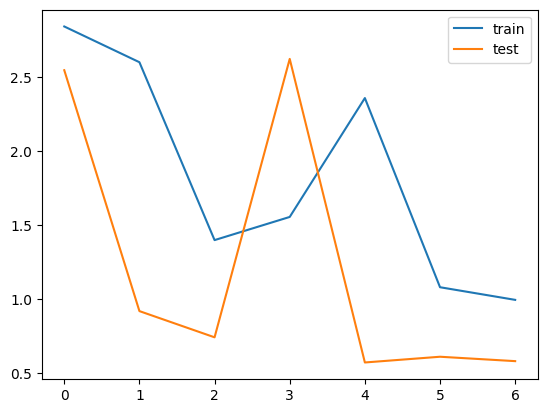

In [43]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

From the plot, we can infer that validation loss has increased after epoch 17 for 2 successive epochs. Hence, training is stopped at epoch 19.

Next, let’s build the dictionary to convert the index to word for target and source vocabulary:

In [44]:
reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
target_word_index=y_tokenizer.word_index

In [ ]:
reverse_source_word_index

# Inference

Set up the inference for the encoder and decoder:

In [46]:
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs)
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat)

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

We are defining a function below which is the implementation of the inference process (which we covered [here](https://www.analyticsvidhya.com/blog/2019/06/comprehensive-guide-text-summarization-using-deep-learning-python/)):

In [51]:
def decode_sequence(input_seq):
    #print("Input seq ",input_seq)
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    #print("enc ",e_out)
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))

    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index.get(sampled_token_index, 'oovtok')

        #----------------------------------------


        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

Let us define the functions to convert an integer sequence to a word sequence for summary as well as the reviews:

In [54]:
# def seq2summary(input_seq):
#     newString=''
#     for i in input_seq:
#         if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
#             newString=newString+reverse_target_word_index[i]+' '
#     return newString

def seq2summary(input_seq):
    newString = ''
    for i in input_seq:
        if i in reverse_target_word_index:
            word = reverse_target_word_index[i]
            if word != 'sostok' and word != 'eostok':
                newString += word + ' '
    return newString.strip()


def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

In [52]:
print(decode_sequence(x_tr[i].reshape(1,max_text_len)))

1/1 [==============================] - 0s 41ms/step
 oovtok oovtok oovtok oovtok oovtok oovtok oovtok oovtok oovtok oovtok oovtok oovtok oovtok oovtok oovtok oovtok oovtok oovtok oovtok oovtok


Here are a few summaries generated by the model:

In [55]:
for i in range(0,6):
    print("Review:",seq2text(x_tr[i]))

    print("Original summary:",seq2summary(y_tr[i]))
    print("Predicted summary:",decode_sequence(x_tr[i].reshape(1,max_text_len)))
    print("\n")

Review: final mercedes go second cars vettel team could hamilton said belgian vandoorne team button vandoorne th button th final good mercedes qualifying vettel one two final practice cars qualifying first vettel hamilton made final first hamilton last final secs practice first qualifying session vettel final last secs hamilton could mercedes race vettel said last year race good try time vandoorne crash first race two belgian car first practice final practice final session button first qualifying session vandoorne secs year old said could good team qualifying button secs vandoorne first session final second good good qualifying race first race go said saturday qualifying one th team final time end session minutes end first session cars end second session one car minutes go two cars go final minutes time qualifying said would said cars team second session way team th mercedes th car qualifying 
Original summary: to at the of
1/1 [==============================] - 0s 22ms/step
Predicted 

This is really cool stuff. Even though the actual summary and the summary generated by our model do not match in terms of words, both of them are conveying the same meaning. Our model is able to generate a legible summary based on the context present in the text.

This is how we can perform text summarization using deep learning concepts in Python.

#How can we Improve the Model’s Performance Even Further?

Your learning doesn’t stop here! There’s a lot more you can do to play around and experiment with the model:

I recommend you to **increase the training dataset** size and build the model. The generalization capability of a deep learning model enhances with an increase in the training dataset size

Try implementing **Bi-Directional LSTM** which is capable of capturing the context from both the directions and results in a better context vector

Use the **beam search strategy** for decoding the test sequence instead of using the greedy approach (argmax)

Evaluate the performance of your model based on the **BLEU score**

Implement **pointer-generator networks** and **coverage mechanisms**




#End Notes

If you have any feedback on this article or any doubts/queries, kindly share them in the comments section over [here](https://www.analyticsvidhya.com/blog/2019/06/comprehensive-guide-text-summarization-using-deep-learning-python/) and I will get back to you. And make sure you experiment with the model we built here and share your results with me!